# Cleaning
# 清洗数据

**清理数据**是数据争论的第三步。修复在评估步骤中确定的质量和整洁问题。使用Python和pandas清除在评估中确定的所有问题。

## Gather

In [1]:
import numpy as np
import pandas as pd

pd.set_option('display.max_columns', 100)  # 设置显示数据的最大列数，防止出现省略号…，导致数据显示不全
pd.set_option('expand_frame_repr', False)  # 当列太多时不自动换行

In [2]:
patients = pd.read_csv('../Assess/patients.csv')
treatments = pd.read_csv('../Assess/treatments.csv')
adverse_reactions = pd.read_csv('../Assess/adverse_reactions.csv')

## Access

### Quality
#####  *`treatment`表*
- 丢失数据(应该350名患者，实际280)
- 缺少hba1c_change
- 'auralin`和`novodra`列中的起始剂量和最终剂量旁边的'u'
- 小写名称
- 错误数据类型（zip_code, assigned sex, state, birthday）
- 错误的HbA1c change

##### `patients`表
- zip_code格式不佳（例如，四位数和浮点数据类型而不是五位数字和字符串或对象数据类型）
- 患者身高值不正确（例如，Tim Neudorf身高27英寸而不是72英寸）
- state不一致(有时是完整的州名，有时是缩写)
- Dsvid 拼写错误，应该是David
- 错误数据类型（auranlin and novodra colums）
- 话号码格式不一致
- 有不可恢复的无名氏记录
- Jakobsen, Gersten, Taylor有多项记录
- Zaitseva的重量单位是“kgs”而不是“lbs”（磅）

##### `adverse_reactions`表
- 小写名称

### Tidiness
- 联系人列表中，电话和邮箱应该分为两列
- 治疗表中，将auranlin and novodra 分为三个变量（treatment, start does and end does）

## Clean

![title](https://raw.githubusercontent.com/hufe09/GitNote-Images/master/gitnote/2019/04/26/1556209407985-1556209407997.png)

### copy一份原数据，命名为*_clean

在进行任何清洁之前，首先要做的是复制每个数据。所有清洁操作都将在此副本上进行，因此您以后仍可以查看原始的脏和/或凌乱的数据集。使用该`copy()`方法在pandas中复制DataFrame 。如果调用了原始DataFrame df，则可以命名即将要清理的数据集副本`df_clean`。

In [3]:
patients_clean = patients.copy()
patients_clean.sample(3)

,patient_id,assigned_sex,given_name,surname,address,city,state,zip_code,country,contact,birthdate,weight,height,bmi
121,122,male,Frydryk,Adamski,1845 Saint Marys Avenue,Syracuse,New York,13221.0,United States,FrydrykAdamski@armyspy.com1 315 869 4408,10/12/1941,230.8,76,28.1
311,312,female,Erica,MacDonald,2011 Eastland Avenue,Philadelphia,MS,39350.0,United States,EricaMacDonald@teleworm.us601-389-7682,5/4/1937,171.4,63,30.4
428,429,male,Marko,Kos,1128 Jacobs Street,Pittsburgh,PA,15212.0,United States,412-319-0903MarkoKos@einrot.com,10/21/1982,227.7,69,33.6


In [4]:
treatments_clean = treatments.copy()
treatments_clean.sample(3)

,given_name,surname,auralin,novodra,hba1c_start,hba1c_end,hba1c_change
7,eddie,archer,31u - 38u,-,7.89,7.55,0.34
141,johana,hrdá,54u - 54u,-,7.79,7.49,0.30
164,felicijan,bubanj,62u - 75u,-,7.85,7.50,0.35


In [5]:
adverse_reactions_clean = adverse_reactions.copy()
adverse_reactions_clean.sample(3)

,given_name,surname,adverse_reaction
12,abdul-nur,isa,hypoglycemia
27,idalia,moore,hypoglycemia
2,joseph,day,hypoglycemia


### Clean for [Tidiness]

#### 联系人列表中，电话和邮箱应该分为两列

*pandas.Series.str.extract [来源]*  
`Series.str.extract(pat, flags=0, expand=True)`  

对于系列中的每个主题字符串，从正则表达式pat的第一个匹配中提取组。  

**参数：**	
- `pat` ： 字符串
具有捕获组的正则表达式模式。

- `flags` ： int，默认为0（无标志）
来自re模块的标志，例如re.IGNORECASE，修改正则表达式匹配，例如大小写，空格等。有关详细信息，请参阅re。

- `expand` ： bool，默认为True
如果为True，则返回DataFrame，每个捕获组一列。如果为False，如果有一个捕获组，则返回系列/索引;如果有多个捕获组，则返回DataFrame。

**返回：**	
**DataFrame或系列或索引**  
一个DataFrame，每个主题字符串有一行，每个组有一列。正则表达式pat中的任何捕获组名称都将用于列名称; 否则将使用捕获组编号。即使找不到匹配项，每个结果列的dtype也始终为object。如果 expand=False和pat只有一个捕获组，则返回一个系列（如果主题是系列）或索引（如果主题是索引）。

- phone_number
    - str.extract(regEx, expand=True) return a new DataFrame with n columns(defined by the number of group in regEx).
    - (
    - (?: : left paren will not count as a group result.
    - \+\d{1,2}\s)?
    - \(?
    - \d{3}
    - \)?
    - [\s.-]?\d{3}[\s.-]?\d{4}
    - )

In [6]:
patients_clean['phone_number'] = patients_clean.contact.str.extract(
    '((?:\+\d{1,2}\s)?\(?\d{3}\)?[\s.-]?\d{3}[\s.-]\d{4})', expand=True)
patients_clean['phone_number'].head()

0         951-719-9170
1    +1 (217) 569-3204
2         402-363-6804
3    +1 (732) 636-8246
4         334-515-7487
Name: phone_number, dtype: object

- email
    - str.extract(regEx, expand=True) return a new DataFrame with n columns(defined by the number of group in regEx).
    - (
    - [a-zA-Z][a-zA-Z0-9_.+-]+
    - @[a-zA-Z0-9-]+\.[a-zA-Z0-9-.]+[a-zA-Z]
    - )

In [7]:
patients_clean['email'] = patients_clean.contact.str.extract(
    '([a-zA-Z][a-zA-Z0-9_.+-]+@[a-zA-Z0-9-]+\.[a-zA-Z0-9-.]+[a-zA-Z])',
    expand=True)
patients_clean['email'].sample(3)

357       ChiemelaTobeolisa@rhyta.com
301    OnyekachukwuObinna@teleworm.us
452      FearneMcGregor@superrito.com
Name: email, dtype: object

- 删除原数据

In [8]:
patients_clean = patients_clean.drop('contact', axis=1)

In [9]:
patients_clean.sample(1)

,patient_id,assigned_sex,given_name,surname,address,city,state,zip_code,country,birthdate,weight,height,bmi,phone_number,email
124,125,male,Ming,Hsu,2945 Ferguson Street,Quincy,MA,2169.0,United States,11/4/1960,215.6,69,31.8,+1 (508) 526-3432,MingHsu@armyspy.com


#### 治疗表中，将auranlin and novodra 分为三个变量（treatment, start does and end does）

*pandas.melt [源]*  
`pandas.melt(frame, id_vars=None, value_vars=None, var_name=None, value_name='value', col_level=None)`  
将DataFrame从宽格式展开为长格式，可选择保留标识符变量集。  

此函数可用于将DataFrame按压为一个或多个列为标识符变量（`id_vars`）的格式，而所有其他列（被视为测量变量（`value_vars`））对行轴“未分配”，只留下两个非标识符列，"变量"和"值"。

**参数：**	
- **`frame`** ： DataFrame
- **`id_vars`** ： tuple，list或ndarray，可选
用作标识符变量的列。

- **`value_vars`** ： tuple，list或ndarray，可选
要拆开的列。如果未指定，则使用未设置为id_vars的所有列。

- **`var_name`** ： 标量
用于“变量”列的名称。如果没有它使用 `frame.columns.name`或`变量`。

- **`value_name`** ： 标量，默认值`value`
用于“值”列的名称。

- **`col_level`** ： `int`或`string`，可选
如果列是MultiIndex，则使用此级别进行融合。

- From Wide to Long
- `df2 = pd.melt(df, id_vars=['unaffected_col', 'unaffected_col', ..], var_name="categorical_col", value_name="numerical_col")`
- str.split(str='', num=n)
    - str: This is any delimeter, by default it is space.
    - num: this is number of lines minus one

In [10]:
treatments_clean = pd.melt(treatments_clean,
                           id_vars=[
                               'given_name', 'surname', 'hba1c_start',
                               'hba1c_end', 'hba1c_change'
                           ],
                           var_name='treatment',
                           value_name='does')
treatments_clean.head()

,given_name,surname,hba1c_start,hba1c_end,hba1c_change,treatment,does
0,veronika,jindrová,7.63,7.20,NaN,auralin,41u - 48u
1,elliot,richardson,7.56,7.09,0.97,auralin,-
2,yukitaka,takenaka,7.68,7.25,NaN,auralin,-
3,skye,gormanston,7.97,7.62,0.35,auralin,33u - 36u
4,alissa,montez,7.78,7.46,0.32,auralin,-


In [11]:
treatments_clean = treatments_clean[treatments_clean.does != '-']
treatments_clean.head()

,given_name,surname,hba1c_start,hba1c_end,hba1c_change,treatment,does
0,veronika,jindrová,7.63,7.20,NaN,auralin,41u - 48u
3,skye,gormanston,7.97,7.62,0.35,auralin,33u - 36u
6,sophia,haugen,7.65,7.27,0.38,auralin,37u - 42u
7,eddie,archer,7.89,7.55,0.34,auralin,31u - 38u
9,asia,woźniak,7.76,7.37,NaN,auralin,30u - 36u


In [12]:
treatments_clean['does_start'], treatments_clean[
    'does_end'] = treatments_clean['does'].str.split(' - ', 1).str
treatments_clean.head()

,given_name,surname,hba1c_start,hba1c_end,hba1c_change,treatment,does,does_start,does_end
0,veronika,jindrová,7.63,7.20,NaN,auralin,41u - 48u,41u,48u
3,skye,gormanston,7.97,7.62,0.35,auralin,33u - 36u,33u,36u
6,sophia,haugen,7.65,7.27,0.38,auralin,37u - 42u,37u,42u
7,eddie,archer,7.89,7.55,0.34,auralin,31u - 38u,31u,38u
9,asia,woźniak,7.76,7.37,NaN,auralin,30u - 36u,30u,36u


In [13]:
treatments_clean = treatments_clean.drop('does', axis=1)
treatments_clean.head()

,given_name,surname,hba1c_start,hba1c_end,hba1c_change,treatment,does_start,does_end
0,veronika,jindrová,7.63,7.20,NaN,auralin,41u,48u
3,skye,gormanston,7.97,7.62,0.35,auralin,33u,36u
6,sophia,haugen,7.65,7.27,0.38,auralin,37u,42u
7,eddie,archer,7.89,7.55,0.34,auralin,31u,38u
9,asia,woźniak,7.76,7.37,NaN,auralin,30u,36u


- 分割`u`,并转换为整数： `Series.str.strip('u').astype(int)`

In [14]:
treatments_clean.does_start = treatments_clean.does_start.str.strip(
    'u').astype(int)
treatments_clean.does_end = treatments_clean.does_end.str.strip('u').astype(
    int)
treatments_clean.head()

,given_name,surname,hba1c_start,hba1c_end,hba1c_change,treatment,does_start,does_end
0,veronika,jindrová,7.63,7.20,NaN,auralin,41,48
3,skye,gormanston,7.97,7.62,0.35,auralin,33,36
6,sophia,haugen,7.65,7.27,0.38,auralin,37,42
7,eddie,archer,7.89,7.55,0.34,auralin,31,38
9,asia,woźniak,7.76,7.37,NaN,auralin,30,36


- `treatments`表，计算剂量改变

In [15]:
treatments_clean["does_change"] = treatments_clean[
    "does_start"] - treatments_clean["does_end"]

In [16]:
treatments_clean.head()

,given_name,surname,hba1c_start,hba1c_end,hba1c_change,treatment,does_start,does_end,does_change
0,veronika,jindrová,7.63,7.20,NaN,auralin,41,48,-7
3,skye,gormanston,7.97,7.62,0.35,auralin,33,36,-3
6,sophia,haugen,7.65,7.27,0.38,auralin,37,42,-5
7,eddie,archer,7.89,7.55,0.34,auralin,31,38,-7
9,asia,woźniak,7.76,7.37,NaN,auralin,30,36,-6


#### 不良反应表应该是治疗表的一部分

- `pd.concat()`: 当有**相同的列名**时
    - `df_new = pd.concat([df_a, df_b])`: 垂直堆叠。
    - `df_new = pd.concat([df_a, df_b], axis=1)`: 水平堆叠(重复的列)
    - `df_a.append(df_b, ignore_index=True)`: stacking vertically.
- `pd.merge()`: 当有**不同的列名**时。它需要公共的“key”(ID)列。
    - `df_new2 = pd.merge(df_new, df_c, on='id', how='inner'/'outer'/'left'/'right')`
- `df.join()`: 当具有**不同的列名**但没有公共的"键”列和“不同索引”列时。
    - `df_new3 = df_new2.join(df_d)`

In [17]:
treatments_clean = pd.merge(treatments_clean,
                            adverse_reactions_clean,
                            on=['given_name', 'surname'],
                            how='left')
treatments_clean.sample()

,given_name,surname,hba1c_start,hba1c_end,hba1c_change,treatment,does_start,does_end,does_change,adverse_reaction
118,hường,lâm,7.66,7.29,0.37,auralin,40,49,-9,NaN


In [18]:
treatments_clean.adverse_reaction.value_counts()

hypoglycemia                 18
headache                      3
injection site discomfort     2
throat irritation             2
nausea                        1
cough                         1
Name: adverse_reaction, dtype: int64

#### 在患者，治疗和不良反应表中，“given_name”和“surname”栏是重复的
`df.drop(['row_a', 'row_b'])`: 根据列名删除列  

`df.frop(df.index[0], inplace = True)`: 根据索引删除列

`df.drop['col_c'], axis=1, inplace = True`：根据列名删除列

In [19]:
id_names = patients_clean[['patient_id', 'given_name', 'surname']]
id_names['given_name'] = id_names['given_name'].str.lower()
id_names['surname'] = id_names['surname'].str.lower()
treatments_clean = pd.merge(treatments_clean,
                            id_names,
                            on=['given_name', 'surname'])
treatments_clean = treatments_clean.drop(['given_name', 'surname'], axis=1)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


#### Patient ID 应该为单独列，不能重复

In [20]:
all_colums = pd.Series(list(patients_clean) + list(treatments_clean))
all_colums

0           patient_id
1         assigned_sex
2           given_name
3              surname
4              address
5                 city
6                state
7             zip_code
8              country
9            birthdate
10              weight
11              height
12                 bmi
13        phone_number
14               email
15         hba1c_start
16           hba1c_end
17        hba1c_change
18           treatment
19          does_start
20            does_end
21         does_change
22    adverse_reaction
23          patient_id
dtype: object

In [21]:
all_colums[all_colums.duplicated()]

23    patient_id
dtype: object

### Clean for [Quality]

#### 修复缺失值1

- `treatments`表中，丢失数据(应该350名患者，实际280)  
   - 假设丢失的数据存储在我们本地名为`treatments_cut`的df中。  
   - 一般来说，我们使用`df.dropna(subset=['col','col'...], inplace=True)`   
   -  => “treatments_cut.csv”导入数据帧，并将其与原始治疗数据帧连接。

In [22]:
# treatments_cut = pd.read_csv('treatments.csv')

In [23]:
# treatments_clean = pd.concat([treatments_clean, treatments_cut], ignore_index= True)
# treatments_clean

- `treatments`表中，缺少`hba1c_change` 
    - => 重新计算`hba1c_change`列: `hba1c_start` - `hba1c_end`

In [24]:
treatments_clean.hba1c_change = (treatments_clean.hba1c_start -
                                 treatments_clean.hba1c_end)
treatments_clean.head()

,hba1c_start,hba1c_end,hba1c_change,treatment,does_start,does_end,does_change,adverse_reaction,patient_id
0,7.63,7.20,0.43,auralin,41,48,-7,NaN,225
1,7.97,7.62,0.35,auralin,33,36,-3,NaN,242
2,7.65,7.27,0.38,auralin,37,42,-5,NaN,345
3,7.89,7.55,0.34,auralin,31,38,-7,NaN,276
4,7.76,7.37,0.39,auralin,30,36,-6,NaN,15


#### 修复数据类型

 - `patients`表中
     - => 将邮政编码列的数据类型从浮点数转换为字符串使用`Series.astype()`
     - => 使用字符串切片`str[:-2]`删除`“.0”`，并使用前导0填充四位数邮政编码
         - `Series.str.pad(width, side='left', fillchar='')`:用附加字符填充序列中的字符串到指定的一侧。
             - `width`:结果字符串的最小宽度；其他字符将用空格填充。
             -  我们期望字符串宽度为5。如果小于5，用“0”填充，使其成为“5”。

In [25]:
patients_clean.zip_code = patients_clean.zip_code.astype(str).str[:-2].str.pad(
    5, fillchar='0')
patients_clean.zip_code.value_counts()

0000n    12
12345     6
30303     4
10004     4
70112     3
35203     3
01730     3
11590     3
98109     3
90017     3
11530     3
60148     3
15205     3
10011     3
10001     2
95134     2
07087     2
70001     2
13221     2
19108     2
68324     2
97205     2
02110     2
10016     2
94108     2
12771     2
33323     2
92103     2
34471     2
12207     2
         ..
55114     1
90007     1
77591     1
24504     1
76102     1
58203     1
56358     1
85012     1
65066     1
96001     1
24153     1
93550     1
45236     1
77074     1
92618     1
12303     1
32810     1
56230     1
32114     1
39401     1
14214     1
46312     1
77063     1
10570     1
58102     1
39350     1
33106     1
02038     1
32548     1
02905     1
Name: zip_code, Length: 431, dtype: int64

![title](https://raw.githubusercontent.com/hufe09/GitNote-Images/master/gitnote/2019/04/25/1556207488282-1556207488682.png)

- => Reconvert NaNs entries that were converted to '0000n' by code above.
    - np.nan is "NaN" in python

In [26]:
patients_clean.zip_code = patients_clean.zip_code.replace('0000n', np.nan)
patients_clean.zip_code.value_counts()

12345    6
10004    4
30303    4
70112    3
35203    3
90017    3
11590    3
01730    3
15205    3
60148    3
11530    3
98109    3
10011    3
11227    2
94612    2
13221    2
74116    2
68324    2
92101    2
12771    2
60605    2
02908    2
40507    2
70001    2
02110    2
23602    2
19108    2
34471    2
94108    2
92103    2
        ..
90007    1
77591    1
24504    1
33301    1
40823    1
02142    1
58203    1
56358    1
96001    1
24153    1
93550    1
45236    1
77074    1
92618    1
12303    1
32810    1
56230    1
32114    1
39401    1
14214    1
46312    1
77063    1
10570    1
58102    1
39350    1
33106    1
02038    1
32548    1
85012    1
02905    1
Name: zip_code, Length: 430, dtype: int64

- `patients` 表: `assigned_sex`, `state`, `zip_code`, and `birthdate` 数据类型错误
- 在`treatments`表中，auranlin and novodra列在开始和结束剂量中带有不必要的字母`u`。
     - => 将`assigned_sex`和`state`转换为分类数据类型。
     
     上面已经解决了`zip_code`数据类型。
     
     将“生日”转换为日期时间数据类型。
     
     在开始剂量和结束剂量中去掉字母`u`，并将这些列转换为数据类型整数。
     - `str()` 单个字符串
     - `.astype(str)` 字符串集

转换为分类类型：`Series.astype('category')`

In [27]:
patients_clean.assigned_sex = patients_clean.assigned_sex.astype('category')
patients_clean.state = patients_clean.state.astype('category')

转换为日期格式： `pd.to_datetime(Series)`

In [28]:
patients_clean.birthdate = pd.to_datetime(patients_clean.birthdate)

In [29]:
treatments_clean.head()

,hba1c_start,hba1c_end,hba1c_change,treatment,does_start,does_end,does_change,adverse_reaction,patient_id
0,7.63,7.20,0.43,auralin,41,48,-7,NaN,225
1,7.97,7.62,0.35,auralin,33,36,-3,NaN,242
2,7.65,7.27,0.38,auralin,37,42,-5,NaN,345
3,7.89,7.55,0.34,auralin,31,38,-7,NaN,276
4,7.76,7.37,0.39,auralin,30,36,-6,NaN,15


In [30]:
patients_clean.head()

,patient_id,assigned_sex,given_name,surname,address,city,state,zip_code,country,birthdate,weight,height,bmi,phone_number,email
0,1,female,Zoe,Wellish,576 Brown Bear Drive,Rancho California,California,92390,United States,1976-07-10,121.7,66,19.6,951-719-9170,ZoeWellish@superrito.com
1,2,female,Pamela,Hill,2370 University Hill Road,Armstrong,Illinois,61812,United States,1967-04-03,118.8,66,19.2,+1 (217) 569-3204,PamelaSHill@cuvox.de
2,3,male,Jae,Debord,1493 Poling Farm Road,York,Nebraska,68467,United States,1980-02-19,177.8,71,24.8,402-363-6804,JaeMDebord@gustr.com
3,4,male,Liêm,Phan,2335 Webster Street,Woodbridge,NJ,07095,United States,1951-07-26,220.9,70,31.7,+1 (732) 636-8246,PhanBaLiem@jourrapide.com
4,5,male,Tim,Neudorf,1428 Turkey Pen Lane,Dothan,AL,36303,United States,1928-02-18,192.3,27,26.1,334-515-7487,TimNeudorf@cuvox.de


#### 修复缺失值2

1. 患者身高值不正确（例如，Tim Neudorf身高27英寸而不是72英寸）  
    => 将患者表格中高度为27英寸(只有一个)的行的高度替换为72英寸
    - `Series.replace(oldvalue, newvalue)`
2. state不一致(有时是完整的州名，有时是缩写)  
    => 应用将California, New York, Illinois, Florida, and Nebraska的全名转换为缩写的函数
    - `if Series in DICT.keys():`
    - `df.apply(func, axis=1)`
3. Dsvid 拼写错误，应该是David  
    => 将患者表中给定名称为“Dsvid”的行的名字替换为“David”
    - `Series.replace(oldvalue, newvalue)`
4. 话号码格式不一致  
    => 去掉所有" "、"-"、"("、")和"+"，并存储每个数字，不进行任何格式化。如果电话号码的长度是10位数字(我们需要国家代码)，请用1填充电话号码
    - `Series.str.replace(r'\D+', '').str.pad(11, fillchar='1')`
5. 有不可恢复的无名字的记录  
    => 从患者表中删除不可恢复的John Doe记录记录
    - `df = df[Series != value]`
6. Jakobsen, Gersten, Taylor有多项记录  
     => 将akobsen, Gersten, Taylor从患者表中移除，这些昵称碰巧也不在治疗表中(删除错误的名称会在患者和治疗表之间产生一致性问题)。这些都是重复的第二次出现。这些也是唯一出现的非空重复地址
     - tilde(~) 表示no
     - `df = df[~(Series.duplicated()) & Series.notnull]`
7. Zaitseva的重量用“kgs”而不是“lbs”（磅）  
    => 使用高级索引隔离姓为Zaitseva的行，并将`weight`字段中的条目从kg转换为lbs
    - `df.loc[row_index, column_index] = a value we want`
    - `df.loc[selection criteria, columns i want] = a value we want`
    - `df.loc[selection criteria, a list of cols] df.loc[selection criteria, a list of cols].values(+, -, *, / ... a calculation I want)`

=> 1. 患者身高值不正确（例如，Tim Neudorf身高27英寸而不是72英寸）

In [31]:
patients_clean.height = patients_clean.replace(27, 72)

=> 2. 应用将California, New York, Illinois, Florida, and Nebraska的全名转换为缩写的函数

In [32]:
state_abbrev = {
    'California': 'CA',
    'New York': 'NY',
    'Illinois': 'IL',
    'Florida': 'FL',
    'Nebraska': 'NE'
}


def abbreviate_state(df):
    if df['state'] in state_abbrev.keys():
        abbrev = state_abbrev[df['state']]
        return abbrev
    else:
        return df['state']


patients_clean['state'] = patients_clean.apply(abbreviate_state, axis=1)

patients_clean.state.value_counts()

CA    60
NY    47
TX    32
IL    24
FL    22
MA    22
PA    18
GA    15
OH    14
MI    13
LA    13
OK    13
NJ    12
VA    11
MS    10
WI    10
MN     9
AL     9
IN     9
TN     9
KY     8
NC     8
WA     8
MO     7
KS     6
ID     6
NV     6
NE     6
CT     5
SC     5
IA     5
ND     4
AR     4
AZ     4
CO     4
RI     4
ME     4
OR     3
SD     3
MD     3
DE     3
WV     3
VT     2
DC     2
MT     2
NM     1
AK     1
NH     1
WY     1
Name: state, dtype: int64

In [33]:
patients_clean.state.unique()

array(['CA', 'IL', 'NE', 'NJ', 'AL', 'FL', 'NV', 'MO', 'NY', 'MI', 'TN',
       'VA', 'OK', 'GA', 'MT', 'MA', 'NM', 'LA', 'PA', 'CO', 'ME', 'WI',
       'SD', 'MN', 'WY', 'OH', 'IA', 'NC', 'IN', 'CT', 'KY', 'DE', 'MD',
       'AZ', 'TX', 'AK', 'ND', 'KS', 'MS', 'WA', 'SC', 'WV', 'RI', 'NH',
       'OR', nan, 'VT', 'ID', 'DC', 'AR'], dtype=object)

=> 3. 将患者表中给定名称为“Dsvid”的行的名字替换为“David”

In [34]:
patients_clean.given_name = patients_clean.given_name.replace('Dsvid', 'David')

=> 4. 去掉所有" "、"-"、"("、")和"+"，并存储每个数字，不进行任何格式化。如果电话号码的长度是10位数字(我们需要国家代码)，请用1填充电话号码

In [35]:
patients_clean.phone_number = patients_clean.phone_number.str.replace(
    r'\D+', '').str.pad(11, fillchar='1')

=> 5. 从患者表中删除不可恢复的John Doe记录

In [36]:
patients_clean = patients_clean[patients_clean.surname != 'Doe']

=> 6. 将akobsen, Gersten, Taylor从患者表中移除，这些昵称碰巧也不在治疗表中

In [37]:
patients_clean = patients_clean[~(patients_clean.address.duplicated())
                                & patients_clean.address.notnull()]

=> 7. 使用高级索引隔离姓为Zaitseva的行，并将weight字段中的条目从kg转换为lbs

In [38]:
weight_kg = patients_clean.weight.sort_values()[0]
patients_clean.loc[patients_clean.surname ==
                   'Zaitseva', 'weight'] = weight_kg * 2.20462

In [39]:
patients_clean.head()

,patient_id,assigned_sex,given_name,surname,address,city,state,zip_code,country,birthdate,weight,height,bmi,phone_number,email
0,1,female,Zoe,Wellish,576 Brown Bear Drive,Rancho California,CA,92390,United States,1976-07-10,121.7,1,19.6,19517199170,ZoeWellish@superrito.com
1,2,female,Pamela,Hill,2370 University Hill Road,Armstrong,IL,61812,United States,1967-04-03,118.8,2,19.2,12175693204,PamelaSHill@cuvox.de
2,3,male,Jae,Debord,1493 Poling Farm Road,York,NE,68467,United States,1980-02-19,177.8,3,24.8,14023636804,JaeMDebord@gustr.com
3,4,male,Liêm,Phan,2335 Webster Street,Woodbridge,NJ,07095,United States,1951-07-26,220.9,4,31.7,17326368246,PhanBaLiem@jourrapide.com
4,5,male,Tim,Neudorf,1428 Turkey Pen Lane,Dothan,AL,36303,United States,1928-02-18,192.3,5,26.1,13345157487,TimNeudorf@cuvox.de


In [40]:
treatments_clean.head()

,hba1c_start,hba1c_end,hba1c_change,treatment,does_start,does_end,does_change,adverse_reaction,patient_id
0,7.63,7.20,0.43,auralin,41,48,-7,NaN,225
1,7.97,7.62,0.35,auralin,33,36,-3,NaN,242
2,7.65,7.27,0.38,auralin,37,42,-5,NaN,345
3,7.89,7.55,0.34,auralin,31,38,-7,NaN,276
4,7.76,7.37,0.39,auralin,30,36,-6,NaN,15


In [41]:
treatments_clean.to_csv('treatments_final.csv', index=False)

In [42]:
treatments_final = pd.read_csv('treatments_final.csv')
treatments_final.head()

,hba1c_start,hba1c_end,hba1c_change,treatment,does_start,does_end,does_change,adverse_reaction,patient_id
0,7.63,7.20,0.43,auralin,41,48,-7,NaN,225
1,7.97,7.62,0.35,auralin,33,36,-3,NaN,242
2,7.65,7.27,0.38,auralin,37,42,-5,NaN,345
3,7.89,7.55,0.34,auralin,31,38,-7,NaN,276
4,7.76,7.37,0.39,auralin,30,36,-6,NaN,15


In [43]:
adverse_reactions_clean.head()

,given_name,surname,adverse_reaction
0,berta,napolitani,injection site discomfort
1,lena,baer,hypoglycemia
2,joseph,day,hypoglycemia
3,flavia,fiorentino,cough
4,manouck,wubbels,throat irritation


用 `patient_id` 代替 `given_name` 和 `surname`

In [ ]:
id_names = patients_clean[['patient_id', 'given_name', 'surname']]
id_names['given_name'] = id_names['given_name'].str.lower()
id_names['surname'] = id_names['surname'].str.lower()
adverse_reactions_clean = pd.merge(adverse_reactions_clean,
                                   id_names,
                                   on=['given_name', 'surname'])
adverse_reactions_clean = adverse_reactions_clean.drop(['given_name', 'surname'], axis=1)

In [67]:
adverse_reactions_clean.head()

,adverse_reaction,patient_id
0,injection site discomfort,477
1,hypoglycemia,128
2,hypoglycemia,70
3,throat irritation,403
4,hypoglycemia,490


## 我们推荐的这款新型口服胰岛素Auralin有效吗？

比较对象是注射型胰岛素Novodra，这里是临床试验的关键指标
- **第一个是不良反应**，如果 Auralin 要通过 II 期临床试验 其安全性就需得到认可，从这里的不良反应来看希望很大
- 第二个关键指标**试验前/后胰岛素平均剂量变化**

    这一指标很重要，如果新型口服胰岛素，需要特别大的剂量才能生效，制造商可能就不会把它推出市场，因为特大剂量从经济角度看是不可行的，即便药物有效能够提高生活质量，但制药行业毕竟是在做生意，有时候，这是个很不幸的现实。
- 关键指标：**HbA1c变化**，HbA1c变化是糖尿病控制的关键指标

下面通过可视化来分析这三个关键指标，得出结论

## 可视化

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

In [46]:
%matplotlib inline
plt.rcParams['axes.unicode_minus'] = False  #用来正常显示负号

from matplotlib.font_manager import FontProperties
font = FontProperties(fname=r"../../fonts/msyh.ttf", size=14)

In [47]:
treatment_group = treatments_final.groupby('treatment')
treatment_group.mean()

,hba1c_start,hba1c_end,hba1c_change,does_start,does_end,does_change,patient_id
treatment,,,,,,,
auralin,7.999927,7.613942,0.385985,39.335766,47.547445,-8.211679,256.233577
novodra,7.974296,7.567676,0.406620,39.929577,39.471831,0.457746,263.563380


### 指标1：不良反应

In [48]:
after_adverse_reactions = treatment_group['adverse_reaction'].value_counts()
after_adverse_reactions

treatment  adverse_reaction         
auralin    hypoglycemia                 9
           throat irritation            2
           headache                     1
           nausea                       1
novodra    hypoglycemia                 9
           headache                     2
           injection site discomfort    2
           cough                        1
Name: adverse_reaction, dtype: int64

其中有些常见的不良反应是咳嗽（cough），头痛（headache），恶心（nausea），最大的反应是低血糖症（hypoglycemia），这种低血糖症状是由过量摄入胰岛素造成的，通常来说是这样的。

在Auralin和Novodra两种药物之间，每种不良反应的人数都差不多
- 除了口服胰岛素Auralin会造成咽部不适（throat irritation），不过这点在意料之内，因为这种药丸是口服的，在到达胃部之前会先经过喉咙
- 而注射型胰岛素Novodra则会造成注射部位不适（injection site discomfort），由于要使用针筒所以这是注射型胰岛素常见的不良反应，这也是病人想用口服胰岛素的一大原因。

**pandas的 `stack()` 、 `unstack()` 和 `pivot()` 这三种方法都是用来对表格进行重排的**
- `stack()` 是将原来的列索引转成了最内层的行索引，这里是多层次索引，其中AB索引对应第三层，即最内层索引。
- `unstack()` 是 `stack()` 的逆操作，这里把最内层的行索引还原成了列索引。但是 `unstack()` 中有一个参数可以指定旋转第几层索引，比如 `unstack(0)` 就是把第一层行索引转成列索引，但默认的是把最内层索引转层列索引。
- `pivot()` 方法其实比较容易理解，就是指定相应的列分别作为行、列索引以及值。
![image](https://raw.githubusercontent.com/hufe09/GitNote-Images/master/Picee/image.qowis8cl0dd.png)

In [49]:
after_adverse_reactions.unstack()

adverse_reaction,cough,headache,hypoglycemia,injection site discomfort,nausea,throat irritation
treatment,,,,,,
auralin,NaN,1.0,9.0,NaN,1.0,2.0
novodra,1.0,2.0,9.0,2.0,NaN,NaN


- 这些统计数据在横向条形图条形图中更为明显

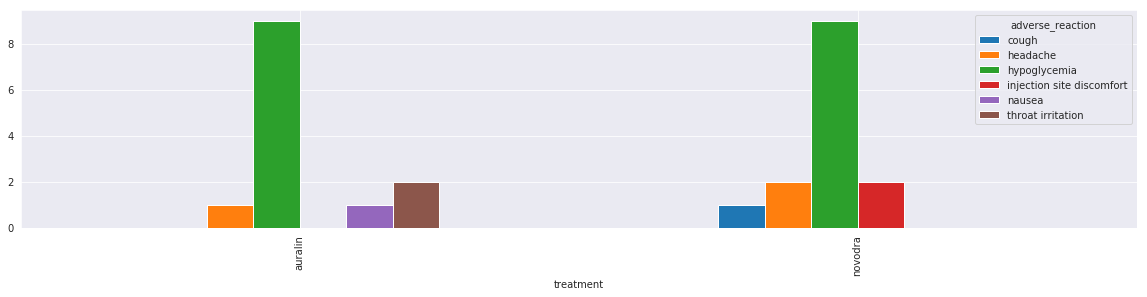

In [50]:
after_adverse_reactions.unstack().plot(kind='bar', figsize=(20, 4))

![image](https://raw.githubusercontent.com/hufe09/GitNote-Images/master/Picee/image.flo86xyg0o8.png)

- 分别绘制横向条形图，更为明显

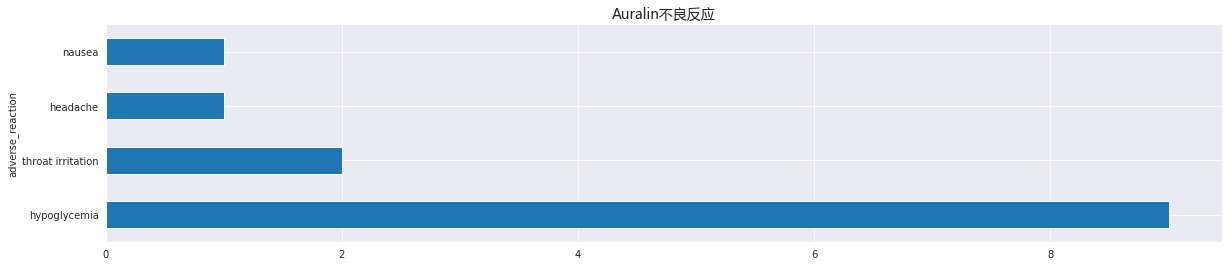

In [51]:
ax = after_adverse_reactions.auralin.plot(
    kind='barh',
    figsize=(20, 4))  #ax是pandas plot的返回实例，它的类是matplotlib的axes对象，里面有很多设置图的方法
ax.set_title('Auralin不良反应', fontproperties=font)  #设置图表的标题，字体为中文字体
plt.show()

![image](https://raw.githubusercontent.com/hufe09/GitNote-Images/master/Picee/image.pfomm2p2o1.png)

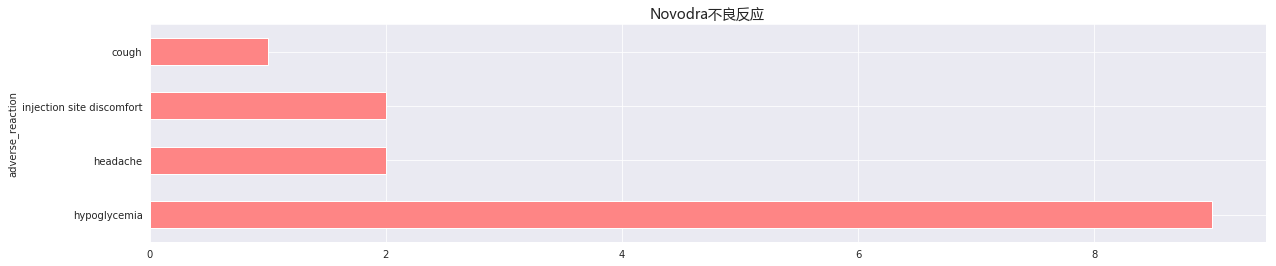

In [52]:
ax = after_adverse_reactions.novodra.plot(
    kind='barh', figsize=(20, 4),
    color='#fe8585')  #ax是pandas plot的返回实例，它的类是matplotlib的axes对象，里面有很多设置图的方法
ax.set_title('Novodra不良反应', fontproperties=font)  #设置图表的标题，字体为中文字体
plt.show()

![image](https://raw.githubusercontent.com/hufe09/GitNote-Images/master/Picee/image.27y8dpmfww.png)

对比下面的循环遍历，Groupby能让我们直接免去循环, 而且不需要烦人的筛选, 一行就完美搞定

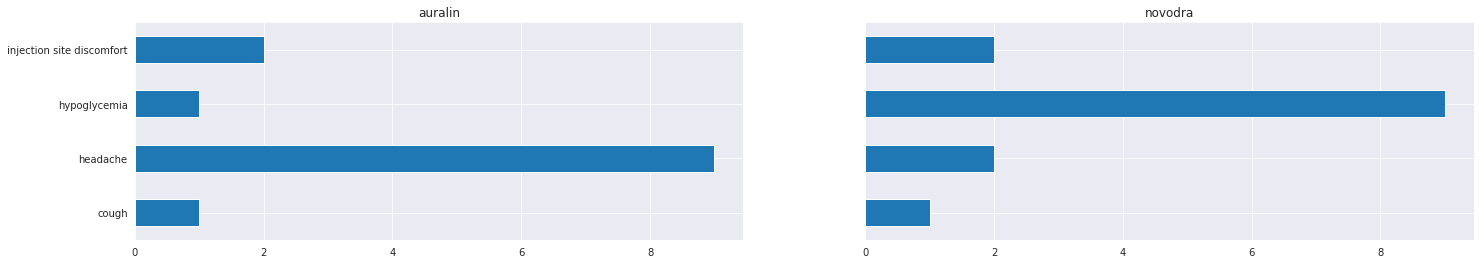

In [53]:
ts = np.sort(treatments_final['treatment'].dropna().unique())
fig, axes = plt.subplots(1, len(ts), figsize=(24, 4), sharey=True)
for ax, t in zip(axes, ts):
    treatments_final[treatments_final['treatment'] ==
                     t]['adverse_reaction'].value_counts().sort_index().plot(
                         kind='barh', ax=ax, title=t)

![image](https://raw.githubusercontent.com/hufe09/GitNote-Images/master/Picee/image.9zy65vymbc5.png)

### 指标2：试验前/后胰岛素平均剂量变化

清洗之前这个剂量信息，实际上藏在了这个治疗表的两列里，即Auralin和Novodra这两列，每一列都藏着起始剂量和结束剂量的数据，而质量剂量的值则分别藏在这两列的列名里，清洗后，将开始剂量，结束剂量，并计算变化剂量，分为三列。
- 清洗前
![image](https://raw.githubusercontent.com/hufe09/GitNote-Images/master/Picee/image.bjq6wv8kh0f.png)
- 清洗后
![image](https://raw.githubusercontent.com/hufe09/GitNote-Images/master/Picee/image.p240n154n5.png)

In [54]:
Auralin = treatment_group.mean().loc['auralin', 'does_change']
Novodra = treatment_group.mean().loc['novodra', 'does_change']
Auralin, Novodra

(-8.211678832116789, 0.45774647887323944)

In [55]:
treatment_group.mean().does_change

treatment
auralin   -8.211679
novodra    0.457746
Name: does_change, dtype: float64

这里的结果也对Auralin有利至少没坏处，这里的 -8有点误导人不过它只是数字设定的问题，-8意思是接受Auralin治疗的患者需要增加平均8个单位的胰岛素，才能维持安全稳定的血糖水平，相比起来Novodra的患者则需要减少平均0.4个单位的胰岛素，这是从两者的起始剂量和结束剂量试验前和试验后的数据对比得出的，Auralin需要多用8个单位并不可怕，而且这算是意料之内，因为我们知道口服胰岛素，很难通过胃粘膜进入到血液中，所以多加8个单位不算什么。

平均剂量变化的不同在下面这个条形图里更为明显，再说一次，剂量变化是起始剂量减结束剂量的结果。

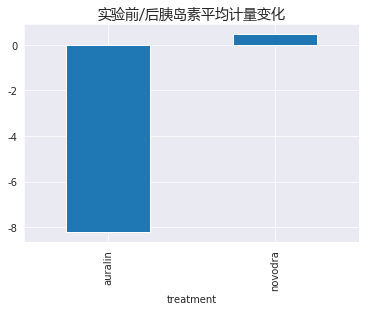

In [56]:
ax = treatment_group.mean().does_change.plot(
    kind='bar')  #ax是pandas plot的返回实例，它的类是matplotlib的axes对象，里面有很多设置图的方法
ax.set_title('实验前/后胰岛素平均计量变化', fontproperties=font)  #设置图表的标题，字体为中文字体
plt.show()

![image](https://raw.githubusercontent.com/hufe09/GitNote-Images/master/Picee/image.4a0et5g03r4.png)

### 指标3：HbA1c变化

#### 清理之前

In [57]:
treatments_original = pd.melt(treatments,
                              id_vars=[
                                  'given_name', 'surname', 'hba1c_start',
                                  'hba1c_end', 'hba1c_change'
                              ],
                              var_name='treatment',
                              value_name='does')
treatments_original = treatments_original[treatments_original.does != '-']
treatments_original['does_start'], treatments_original[
    'does_end'] = treatments_original['does'].str.split(' - ', 1).str
treatments_original = treatments_original.drop('does', axis=1)
treatments_original.head()

,given_name,surname,hba1c_start,hba1c_end,hba1c_change,treatment,does_start,does_end
0,veronika,jindrová,7.63,7.20,NaN,auralin,41u,48u
3,skye,gormanston,7.97,7.62,0.35,auralin,33u,36u
6,sophia,haugen,7.65,7.27,0.38,auralin,37u,42u
7,eddie,archer,7.89,7.55,0.34,auralin,31u,38u
9,asia,woźniak,7.76,7.37,NaN,auralin,30u,36u


In [58]:
treatments_original.groupby('treatment').mean()

,hba1c_start,hba1c_end,hba1c_change
treatment,,,
auralin,7.999927,7.613942,0.344872
novodra,7.972517,7.565664,0.714731


本试验的大部分病人这个指标一开始都在7.9％左右，如果我们能证实Auralin造成的HbA1c水平降低，与现有的注射型胰岛素降低标准相同那就成功了，而衡量这一点的方法是使用置信区间，不过要得到该区间首先要建立均数差，也就是Auralin和Novodra两者，HbA1c平均变化的差别。
![image](https://raw.githubusercontent.com/hufe09/GitNote-Images/master/Picee/image.ui41rp1xga.png)

- 这是清理数据前HbA1c的平均降低值

In [59]:
before_clean_hba1c_change  = treatments_original.groupby('treatment').mean().hba1c_change
before_clean_hba1c_change

treatment
auralin    0.344872
novodra    0.714731
Name: hba1c_change, dtype: float64

在清理之前Novadra在降低HbA1C水平方面很有优势，幅度为0.71和Auralin的0.35相比，是个很大的不同

- 清理之前的条形图如下

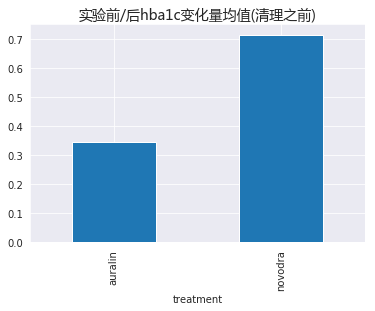

In [60]:
ax = before_clean_hba1c_change.plot(
    kind='bar')  #ax是pandas plot的返回实例，它的类是matplotlib的axes对象，里面有很多设置图的方法
ax.set_title('实验前/后hba1c变化量均值(清理之前)', fontproperties=font)  #设置图表的标题，字体为中文字体
plt.show()

![image](https://raw.githubusercontent.com/hufe09/GitNote-Images/master/Picee/image.mmkbqse6ffd.png)

#### 清理之后

- 这是重新计算这些hba1c变化，清理数据后HbA1c的平均降低值，解决了这些不准确的HbA1c变化数据

In [61]:
after_clean_hba1c_change = treatment_group.mean().hba1c_change
after_clean_hba1c_change

treatment
auralin    0.385985
novodra    0.406620
Name: hba1c_change, dtype: float64

清理后，Novadra为0.40和Auralin的0.39相比好多了，而且平均值的这种微小不同在条形图里更为明显

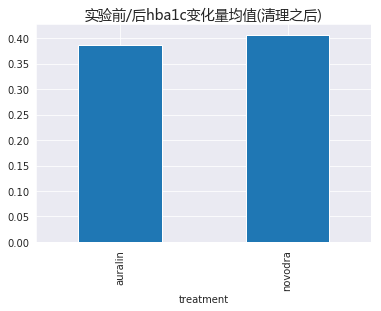

In [62]:
ax = after_clean_hba1c_change.plot(
    kind='bar')  #ax是pandas plot的返回实例，它的类是matplotlib的axes对象，里面有很多设置图的方法
ax.set_title('实验前/后hba1c变化量均值(清理之后)', fontproperties=font)  #设置图表的标题，字体为中文字体
plt.show()

![image](https://raw.githubusercontent.com/hufe09/GitNote-Images/master/Picee/image.s0h2wbf0uk.png)

这样的结果很鼓舞人心不过临床试验结果，需要更严谨的统计分析来确认这一点，准确地说我们要找的统计数据就是置信区间的上限，我们需要一个均数差小于0.4的置信区间也即区间上限应小于0.4。

在清理之前是0.71比0.35，柱形图对比鲜明，无法通过我们的非劣效性指标，置信上限为0.42，这份临床试验数据在没有评估和清理之前，Auralin无法通过II期临床试验

## 置信区间

In [63]:
bootsample = treatments_original.sample(treatments_original.shape[0], replace=True)
mean_auralin = bootsample[bootsample['treatment'] == 'auralin']['hba1c_change'].mean()
mean_novodra = bootsample[bootsample['treatment'] == 'novodra']['hba1c_change'].mean()
mean_novodra - mean_auralin

0.3671060606060608

In [64]:
def confidence_intervals(data_frame, difference_in_means_limit):
    """
    data_frame: 数据集
    difference_in_means_limit： 均数差限制
    out：计算得出置信区间的两个界限（下限，上限）
    
    """
    # 计算置信度
    reliability  = 100 - difference_in_means_limit * 10 
    means = []
    for _ in range(10000):
        bootsample = data_frame.sample(data_frame.shape[0], replace=True)
        mean_auralin = bootsample[bootsample['treatment'] == 'auralin']['hba1c_change'].mean()
        mean_novodra = bootsample[bootsample['treatment'] == 'novodra']['hba1c_change'].mean()
        means.append(mean_novodra - mean_auralin)
    return np.percentile(means, (100-reliability)), np.percentile(means, reliability)

- 清理之前，HbA1c变化均数差置信区间

In [65]:
before_CI_lower_limit, before_CI_upper_limit = confidence_intervals(treatments_original, 0.4)
before_CI_lower_limit, before_CI_upper_limit

(0.3181952882205517, 0.42047837498035506)

- 清理之后，HbA1c变化均数差置信区间

In [66]:
after_CI_lower_limit, after_CI_upper_limit = confidence_intervals(treatments_clean, 0.4)
after_CI_lower_limit, after_CI_upper_limit

(0.00828740605498917, 0.032919389761970556)

不过在好好清理一番后二者的HbA1C下降水平已经很相似了，置信区间也确认了这一点，其上限约为0.03远比0.4小很多，口服胰岛素效用，与注射型胰岛素的相似。

## 结论

**根据这次临床试验来看的话，这意味着什么？**

意味着我们的口服胰岛素通过了II期临床试验，从过去经验来看II期试验是最难通过的，从过去经验来看成功通过II期试验的可能性为31％，而通过II期试验就意味着我们有很大的机会让新药通过III期，以及监管审查流程也很有可能成功地让新药面世，如果真的成功了这款口服胰岛素会是个巨大的突破，而且这款药物能让病人免受每日注射之苦，也能减小病人忘记用药的几率，从而减少糖尿病引起的恼人甚至是严重的并发症，评估数据与清理的作用显而易见，非常重要。

>https://www.nature.com/articles/nrd.2016.136.html
![image](https://raw.githubusercontent.com/hufe09/GitNote-Images/master/Picee/image.em7ue89ue4i.png)

<h5><a href="https://hufe09.github.io/archive/?tag=Data+Wrangling">Hufe Blog</a><h5>